In [2]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Activation, Dense, Dropout

img_height, img_width = (224,224)
batch_size = 32

train_data_dir = r"H:\Forensic-processed_data\train"
valid_data_dir = r"H:\Forensic-processed_data\val"
test_data_dir = r"H:\Forensic-processed_data\test"

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  validation_split=0.4)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size=(img_height, img_width),
batch_size=batch_size,
class_mode='categorical',
subset='training') # set as training data

valid_generator = train_datagen.flow_from_directory(
valid_data_dir, # some directory as training data
target_size=(img_height, img_width),
batch_size=batch_size,
class_mode='categorical',
subset='validation') # set as validation data

Found 478 images belonging to 2 classes.
Found 105 images belonging to 2 classes.


In [4]:
test_generator = train_datagen.flow_from_directory(
test_data_dir, # some directory as training data
target_size=(img_height, img_width),
batch_size=1,
class_mode='categorical',
subset='validation') # set as validation data

Found 105 images belonging to 2 classes.


In [7]:
#without dense layer
base_model = VGG16(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

model.fit(train_generator,
         epochs = 20)

Epoch 1/20
15/15 [==============================] - 45s 3s/step - loss: 2.3306 - accuracy: 0.5690
Epoch 2/20
15/15 [==============================] - 50s 3s/step - loss: 0.8133 - accuracy: 0.6653
Epoch 3/20
15/15 [==============================] - 50s 3s/step - loss: 0.5825 - accuracy: 0.7218
Epoch 4/20
15/15 [==============================] - 50s 3s/step - loss: 0.4603 - accuracy: 0.7762
Epoch 5/20
15/15 [==============================] - 50s 3s/step - loss: 0.4577 - accuracy: 0.7950
Epoch 6/20
15/15 [==============================] - 50s 3s/step - loss: 0.5677 - accuracy: 0.7573
Epoch 7/20
15/15 [==============================] - 50s 3s/step - loss: 0.3964 - accuracy: 0.8201
Epoch 8/20
15/15 [==============================] - 50s 3s/step - loss: 0.3892 - accuracy: 0.8264
Epoch 9/20
15/15 [==============================] - 50s 3s/step - loss: 0.4776 - accuracy: 0.8159
Epoch 10/20
15/15 [==============================] - 50s 3s/step - loss: 0.4192 - accuracy: 0.8033
Epoch 11/20
15/15 [

In [8]:
model.fit(valid_generator, epochs=20)

Epoch 1/20
4/4 [==============================] - 10s 2s/step - loss: 0.6103 - accuracy: 0.7333
Epoch 2/20
4/4 [==============================] - 10s 2s/step - loss: 0.4314 - accuracy: 0.8000
Epoch 3/20
4/4 [==============================] - 10s 2s/step - loss: 0.4422 - accuracy: 0.8095
Epoch 4/20
4/4 [==============================] - 10s 3s/step - loss: 0.3736 - accuracy: 0.8286
Epoch 5/20
4/4 [==============================] - 10s 2s/step - loss: 0.5237 - accuracy: 0.8190
Epoch 6/20
4/4 [==============================] - 11s 3s/step - loss: 0.4830 - accuracy: 0.8571
Epoch 7/20
4/4 [==============================] - 11s 3s/step - loss: 0.4300 - accuracy: 0.8095
Epoch 8/20
4/4 [==============================] - 11s 3s/step - loss: 0.4994 - accuracy: 0.8381
Epoch 9/20
4/4 [==============================] - 11s 3s/step - loss: 0.4064 - accuracy: 0.8476
Epoch 10/20
4/4 [==============================] - 11s 3s/step - loss: 0.2196 - accuracy: 0.8857
Epoch 11/20
4/4 [======================

In [9]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)

105/105 - 12s - loss: 0.6235 - accuracy: 0.8000

Test accuracy: 0.800000011920929


In [10]:
model.save('model_vgg16_1.h5')

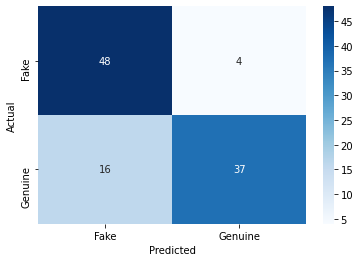

Test accuracy : 80.95238095238095


In [22]:
import pandas as pd
import seaborn as sns
import tensorflow as tf

model = tf.keras.models.load_model(r"model_vgg16_1.h5")
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
    X_test,Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix,cmap='Blues', annot=True,fmt='d')
plt.show()
print('Test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [14]:
#without dense layer
base_model = VGG16(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics = ['accuracy'])

model.fit(train_generator,
         epochs = 20)

Epoch 1/20
15/15 [==============================] - 40s 3s/step - loss: 0.9928 - accuracy: 0.5690
Epoch 2/20
15/15 [==============================] - 41s 3s/step - loss: 0.6783 - accuracy: 0.6402
Epoch 3/20
15/15 [==============================] - 40s 3s/step - loss: 0.6690 - accuracy: 0.6527
Epoch 4/20
15/15 [==============================] - 40s 3s/step - loss: 0.5930 - accuracy: 0.7071
Epoch 5/20
15/15 [==============================] - 41s 3s/step - loss: 0.5600 - accuracy: 0.7197
Epoch 6/20
15/15 [==============================] - 42s 3s/step - loss: 0.5546 - accuracy: 0.7134
Epoch 7/20
15/15 [==============================] - 41s 3s/step - loss: 0.5458 - accuracy: 0.7343
Epoch 8/20
15/15 [==============================] - 41s 3s/step - loss: 0.5178 - accuracy: 0.7699
Epoch 9/20
15/15 [==============================] - 41s 3s/step - loss: 0.5172 - accuracy: 0.7490
Epoch 10/20
15/15 [==============================] - 40s 3s/step - loss: 0.4953 - accuracy: 0.7322
Epoch 11/20
15/15 [

In [15]:
model.fit(valid_generator, epochs=20)

Epoch 1/20
4/4 [==============================] - 7s 2s/step - loss: 0.6719 - accuracy: 0.6286
Epoch 2/20
4/4 [==============================] - 8s 2s/step - loss: 0.6534 - accuracy: 0.6667
Epoch 3/20
4/4 [==============================] - 8s 2s/step - loss: 0.6139 - accuracy: 0.6571
Epoch 4/20
4/4 [==============================] - 9s 2s/step - loss: 0.5276 - accuracy: 0.7333
Epoch 5/20
4/4 [==============================] - 9s 2s/step - loss: 0.5329 - accuracy: 0.7143
Epoch 6/20
4/4 [==============================] - 9s 2s/step - loss: 0.5188 - accuracy: 0.7143
Epoch 7/20
4/4 [==============================] - 10s 2s/step - loss: 0.6415 - accuracy: 0.6762
Epoch 8/20
4/4 [==============================] - 9s 2s/step - loss: 0.5214 - accuracy: 0.7429
Epoch 9/20
4/4 [==============================] - 9s 3s/step - loss: 0.5228 - accuracy: 0.7714
Epoch 10/20
4/4 [==============================] - 9s 3s/step - loss: 0.4619 - accuracy: 0.7810
Epoch 11/20
4/4 [==============================]

In [16]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)

105/105 - 8s - loss: 0.5248 - accuracy: 0.7429

Test accuracy: 0.7428571581840515


In [17]:
model.save('model_vgg16_2.h5')

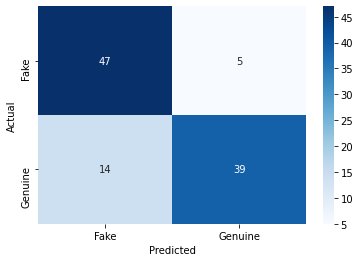

Test accuracy : 81.9047619047619


In [18]:
import pandas as pd
import seaborn as sns
import tensorflow as tf

model = tf.keras.models.load_model(r"model_vgg16_1.h5")
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
    X_test,Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix,cmap='Blues', annot=True,fmt='d')
plt.show()
print('Test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [21]:
#without dense layer
from keras import optimizers
base_model = VGG16(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics = ['accuracy'])

model.fit(train_generator,
         epochs = 20)

AttributeError: module 'keras.utils.generic_utils' has no attribute 'populate_dict_with_module_objects'

In [ ]:
model.fit(valid_generator, epochs=20)

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)

In [ ]:
model.save('model_vgg16_1.h5')

In [ ]:
import pandas as pd
import seaborn as sns
import tensorflow as tf

model = tf.keras.models.load_model(r"model_vgg16_1.h5")
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
    X_test,Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix,cmap='Blues', annot=True,fmt='d')
plt.show()
print('Test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))